In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from time import time
from collections import defaultdict
import nltk
import spacy
import logging 
from string import punctuation
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
con = sqlite3.connect("/content/Wayfair.db")

In [3]:
df = pd.read_sql("SELECT * FROM Comments", con)

In [4]:
df.head()

,author,comment,date,link,parent,submission,score,subreddit
0,Fratetrain91,I will probably never buy from Wayfair after r...,1.594256e+09,t3_hn78zr,hn78zr,hn78zr,3,wayfair
1,CySU,Reading this making me second guess our purcha...,1.594261e+09,t3_hn78zr,hn78zr,hn78zr,5,wayfair
2,PerelandraNative,Thanks for the warning! They sound awful! We w...,1.594329e+09,t3_hn78zr,hn78zr,hn78zr,2,wayfair
3,cooljay790,‘Caveat Emptor’. Buyer Beware. Proceed at your...,1.594337e+09,t3_hn78zr,hn78zr,hn78zr,2,wayfair
4,Elysianfieldflower,I did handy installations for a little while b...,1.594501e+09,t3_hn78zr,hn78zr,hn78zr,1,wayfair


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75418 entries, 0 to 75417
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   author      72911 non-null  object 
 1   comment     75418 non-null  object 
 2   date        75418 non-null  float64
 3   link        75418 non-null  object 
 4   parent      75418 non-null  object 
 5   submission  75418 non-null  object 
 6   score       75418 non-null  int64  
 7   subreddit   75418 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 4.6+ MB


In [6]:
df['date']= pd.to_datetime(df['date'],unit='s')

In [7]:
df.head()

,author,comment,date,link,parent,submission,score,subreddit
0,Fratetrain91,I will probably never buy from Wayfair after r...,2020-07-09 00:50:19,t3_hn78zr,hn78zr,hn78zr,3,wayfair
1,CySU,Reading this making me second guess our purcha...,2020-07-09 02:24:20,t3_hn78zr,hn78zr,hn78zr,5,wayfair
2,PerelandraNative,Thanks for the warning! They sound awful! We w...,2020-07-09 21:18:11,t3_hn78zr,hn78zr,hn78zr,2,wayfair
3,cooljay790,‘Caveat Emptor’. Buyer Beware. Proceed at your...,2020-07-09 23:24:28,t3_hn78zr,hn78zr,hn78zr,2,wayfair
4,Elysianfieldflower,I did handy installations for a little while b...,2020-07-11 20:48:41,t3_hn78zr,hn78zr,hn78zr,1,wayfair


In [8]:
len(df)

75418

In [9]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['comment'])
nlp = spacy.load('en', disable=['ner', 'parser'])
def cleaning_lem(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [10]:
t = time()

txt = [cleaning_lem(doc) for doc in nlp.pipe(brief_cleaning, batch_size=500, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.52 mins


In [11]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(26520, 1)


                                               clean
0  probably buy wayfair read couldn t imagine fee...
1  read make second guess purchase order tv enter...
2  thank warning sound awful look bedroom set sen...
3            caveat emptor buyer beware proceed risk
4  handy installation little like uber let signnu...


In [12]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

INFO - 15:41:35: 'pattern' package not found; tag filters are not available for English


In [13]:
sent = [row.split() for row in df_clean['clean']]

In [14]:
phrases = Phrases(sent, min_count=30, progress_per=100)

INFO - 15:41:35: collecting all words and their counts
INFO - 15:41:35: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:41:35: PROGRESS: at sentence #100, processed 1837 words and 2257 word types
INFO - 15:41:35: PROGRESS: at sentence #200, processed 4316 words and 4941 word types
INFO - 15:41:35: PROGRESS: at sentence #300, processed 6951 words and 7563 word types
INFO - 15:41:35: PROGRESS: at sentence #400, processed 9030 words and 9423 word types
INFO - 15:41:35: PROGRESS: at sentence #500, processed 10755 words and 10749 word types
INFO - 15:41:35: PROGRESS: at sentence #600, processed 12500 words and 12236 word types
INFO - 15:41:35: PROGRESS: at sentence #700, processed 13737 words and 13234 word types
INFO - 15:41:35: PROGRESS: at sentence #800, processed 15075 words and 14335 word types
INFO - 15:41:35: PROGRESS: at sentence #900, processed 16767 words and 15397 word types
INFO - 15:41:35: PROGRESS: at sentence #1000, processed 17955 words and 16343 word 

In [15]:
bigram = Phraser(phrases)

INFO - 15:41:37: source_vocab length 291958
INFO - 15:41:40: Phraser built with 268 phrasegrams


In [16]:
sentences = bigram[sent]

In [17]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

24417

In [18]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['s',
 'wayfair',
 'people',
 'like',
 'think',
 'know',
 'child',
 'thing',
 'name',
 'look']

In [19]:
import multiprocessing
from gensim.models import Word2Vec

In [20]:
cores = multiprocessing.cpu_count()
cores

2

In [21]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=100,
                     sample=6e-5,  
                     negative=20,
                     workers=cores-1)

In [22]:
t = time()

w2v_model.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:41:41: collecting all words and their counts
INFO - 15:41:41: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:41:41: PROGRESS: at sentence #1000, processed 16663 words, keeping 3492 word types
INFO - 15:41:41: PROGRESS: at sentence #2000, processed 33117 words, keeping 5003 word types
INFO - 15:41:41: PROGRESS: at sentence #3000, processed 51523 words, keeping 6409 word types
INFO - 15:41:41: PROGRESS: at sentence #4000, processed 68481 words, keeping 7437 word types
INFO - 15:41:42: PROGRESS: at sentence #5000, processed 85133 words, keeping 8569 word types
INFO - 15:41:42: PROGRESS: at sentence #6000, processed 103216 words, keeping 9512 word types
INFO - 15:41:42: PROGRESS: at sentence #7000, processed 117799 words, keeping 10280 word types
INFO - 15:41:42: PROGRESS: at sentence #8000, processed 133687 words, keeping 10979 word types
INFO - 15:41:42: PROGRESS: at sentence #9000, processed 150491 words, keeping 11663 word types
INFO - 15:41:42: P

Time to build vocab: 0.04 mins


In [23]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:41:43: training model with 1 workers on 2833 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=5
INFO - 15:41:45: EPOCH 1 - PROGRESS: at 49.97% examples, 79292 words/s, in_qsize 0, out_qsize 0
INFO - 15:41:46: EPOCH 1 - PROGRESS: at 96.66% examples, 80909 words/s, in_qsize 0, out_qsize 0
INFO - 15:41:46: worker thread finished; awaiting finish of 0 more threads
INFO - 15:41:46: EPOCH - 1 : training on 464998 raw words (173237 effective words) took 2.1s, 81583 effective words/s
INFO - 15:41:47: EPOCH 2 - PROGRESS: at 49.97% examples, 78414 words/s, in_qsize 0, out_qsize 0
INFO - 15:41:48: EPOCH 2 - PROGRESS: at 96.66% examples, 80457 words/s, in_qsize 0, out_qsize 0
INFO - 15:41:48: worker thread finished; awaiting finish of 0 more threads
INFO - 15:41:48: EPOCH - 2 : training on 464998 raw words (173236 effective words) took 2.1s, 81153 effective words/s
INFO - 15:41:49: EPOCH 3 - PROGRESS: at 49.97% examples, 79526 words/s, in_qsize 0, out_qsize 0


Time to train the model: 1.06 mins


In [24]:
w2v_model.init_sims(replace=True)

INFO - 15:42:47: precomputing L2-norms of word weight vectors


In [25]:
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['wayfair', 'children', 'democrats','media', 'closet','pedophile','qanon','clinton','epstein','sex']}

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [26]:
similar_words

{'children': ['detention_center', 'texas', 'ice', 'furnish', 'furniture'],
 'clinton': ['hillary', 'bill', 'foundation', 'prince', 'wikileak'],
 'closet': ['garage', 'storage', 'locker', 'drawer', 'door'],
 'democrats': ['liberal', 'democrat', 'elect', 'hero', 'threat'],
 'epstein': ['jeffery', 'prince', 'andrew', 'island', 'jr'],
 'media': ['medium', 'pbs_twimg', 'tweet', 'stream', 'fake_news'],
 'pedophile': ['pedo', 'pedophilia', 'predator', 'pedos', 'circle'],
 'qanon': ['right_wing', 'pizzagate', 'batshit', 'sheep', 'hate'],
 'sex': ['predator', 'europe', 'sexually', 'assault', 'trafficker'],
 'wayfair': ['retail', 'expensive_cabinet', 'way_fair', 'wfx', 'furniture']}

Topic Models Now

In [28]:
bool_df = df['comment'].duplicated(keep=False)
df_unique = df[~bool_df]
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9212 entries, 0 to 32259
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   author      9123 non-null   object        
 1   comment     9212 non-null   object        
 2   date        9212 non-null   datetime64[ns]
 3   link        9212 non-null   object        
 4   parent      9212 non-null   object        
 5   submission  9212 non-null   object        
 6   score       9212 non-null   int64         
 7   subreddit   9212 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 647.7+ KB


In [ ]:
df_unique['index'] = np.arange(len(df_unique))

In [30]:
df_unique.head()

,author,comment,date,link,parent,submission,score,subreddit,index
0,Fratetrain91,I will probably never buy from Wayfair after r...,2020-07-09 00:50:19,t3_hn78zr,hn78zr,hn78zr,3,wayfair,0
1,CySU,Reading this making me second guess our purcha...,2020-07-09 02:24:20,t3_hn78zr,hn78zr,hn78zr,5,wayfair,1
2,PerelandraNative,Thanks for the warning! They sound awful! We w...,2020-07-09 21:18:11,t3_hn78zr,hn78zr,hn78zr,2,wayfair,2
3,cooljay790,‘Caveat Emptor’. Buyer Beware. Proceed at your...,2020-07-09 23:24:28,t3_hn78zr,hn78zr,hn78zr,2,wayfair,3
4,Elysianfieldflower,I did handy installations for a little while b...,2020-07-11 20:48:41,t3_hn78zr,hn78zr,hn78zr,1,wayfair,4


In [31]:
import re
def remove_numbers(text):
  text = re.sub("\d+", "", text)
  return text

In [ ]:
df_unique['comment'] = df_unique['comment'].apply(remove_numbers)

In [34]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
import string
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    #return [word for word in nopunc.split() if word.lower() not in my_stopwords]
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [37]:
%time
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
vectoriser = CountVectorizer(analyzer=text_process, max_df=0.95, min_df=0.01)
print('Vectorizer Created')
data = vectoriser.fit_transform(df_unique['comment'])
print('Data Created')
features = vectoriser.get_feature_names()
print('Features Created')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Vectorizer Created
Data Created
Features Created


In [39]:
%time
from sklearn.model_selection import GridSearchCV 
# Define Search Param
search_params = {'n_components': [10,20,30,40,50,60,70,80,90,100], 'doc_topic_prior': [0.01, 0.05, 0.1]}#, 0.2, 0.5]}
#search_params = {'n_components': [10,20,30,40,50,60,70,80,90,100]}

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [40]:
class MyLDAWithPerplexityScorer(LatentDirichletAllocation):

    def score(self, X, y=None):

        # You can change the options passed to perplexity here
        score = super(MyLDAWithPerplexityScorer, self).perplexity(X,sub_sampling=True)

        # Since perplexity is lower for better, so we do negative
        return -1*score
        
lda = MyLDAWithPerplexityScorer(max_iter=5, learning_method='online', learning_offset=50.,
                                random_state=1983,verbose=1)
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1,cv=5,refit = True,verbose=1)
model.fit(data)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 14.2min finished


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


GridSearchCV(cv=5, error_score=nan,
             estimator=MyLDAWithPerplexityScorer(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=5,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=1983,
                                                 topic_word_prior=None,
                                                 total_s

In [41]:
cv = pd.DataFrame(model.cv_results_)

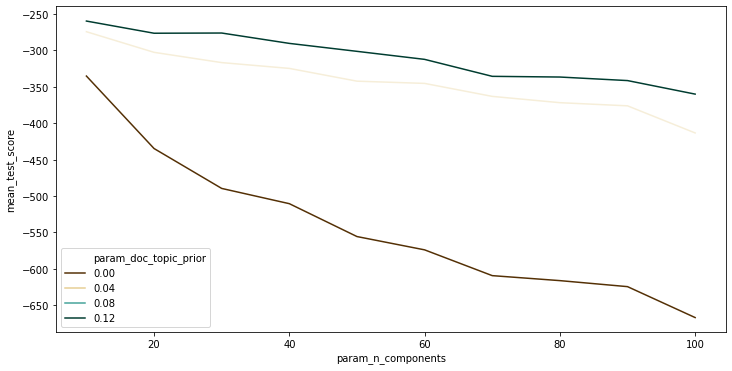

In [54]:
plt.figure(figsize=(12,6))
sns.lineplot(x="param_n_components", y="mean_test_score", data=cv,hue='param_doc_topic_prior',palette='BrBG')

In [55]:
cv_alpha = cv[cv['param_doc_topic_prior'] == 0.01]

In [ ]:
pip install kneed

In [56]:
from kneed import KneeLocator
k = cv_alpha['param_n_components']
per = cv_alpha['mean_test_score']
k = pd.to_numeric(k)
per = pd.to_numeric(per)
kn = KneeLocator(k, per, curve='convex', direction='decreasing')
kn.knee

50

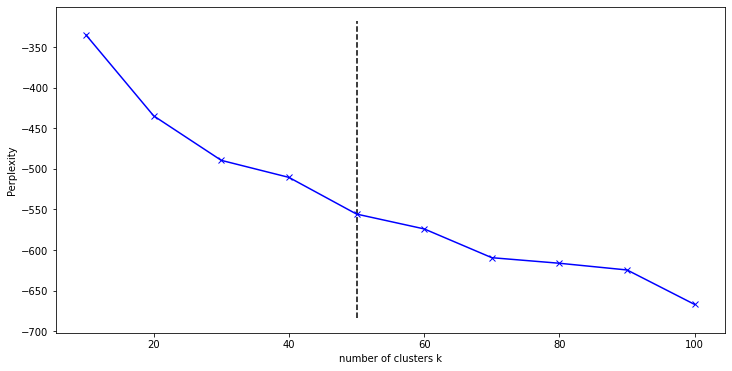

In [57]:
plt.figure(figsize=(12,6))
plt.xlabel('number of clusters k')
plt.ylabel('Perplexity')
plt.plot(k, per, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [58]:
lda_model = LatentDirichletAllocation(doc_topic_prior = 0.01, learning_method='online',n_components=50,n_jobs=-1,verbose=1,random_state = 1983)
lda_output = lda_model.fit_transform(data)
print(lda_model)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.01,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=50, n_jobs=-1,
                          perp_tol=0.1, random_state=1983,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)


In [59]:
theta = pd.DataFrame(lda_output)
theta['index'] = np.arange(len(theta))
theta.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,index
0,0.118824,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.118824,0.001176,0.001176,0.118824,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.118824,0.001176,0.001176,0.118824,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.118824,0.001176,0.236471,0.001176,0.001176,0.001176,0
1,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.668000,0.001333,0.001333,0.001333,0.001333,0.001333,0.268000,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,0.001333,1
2,0.002222,0.002222,0.224444,0.224444,0.002222,0.002222,0.002222,0.002222,0.002222,0.446667,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,2
3,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,3
4,0.042209,0.000377,0.039174,0.000377,0.033136,0.000377,0.000377,0.075849,0.000377,0.038113,0.000377,0.000377,0.038113,0.000377,0.075845,0.000377,0.452880,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.038113,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.038266,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.075849,0.000377,0.000377,0.038113,0.000377,0.000377,4


In [60]:
meta_theta_df = df_unique.join(theta, how='left', on='index', rsuffix = '_theta')

In [ ]:
pd.options.display.max_columns = None
meta_theta_df.head()

In [62]:
mybeta = pd.DataFrame(lda_model.components_)
mybeta.columns = features
mybeta = mybeta.transpose()
mybeta = np.exp(mybeta)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [64]:
nwords = 51

topwords = []
for i in range(0,50,1):
  tempframe = mybeta[i].sort_values(ascending=False)
  tempframe = tempframe[1:nwords]
  #tempvec = tempframe.index.values
  topwords.append(tempframe.index.values)

topwords = pd.DataFrame(topwords).T
topwords.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,dont,expensive,really,back,something,feel,cabinet,It’s,story,one,money,anything,k,world,sub,everyone,someone,still,use,it’s,lot,nothing,going,isnt,prices,work,first,us,got,code,mean,trying,items,put,names,company,fuck,bot,fact,conspiracy,etc,real,children,actual,go,evidence,used,weird,Epstein,girls
1,right,Maybe,found,stock,seen,without,would,new,put,order,human,sex,person,buying,much,making,take,getting,looking,that’s,fucking,kid,made,sure,Wayfair,though,trying,keep,video,didnt,likely,link,item,sell,kids,don’t,might,questions,media,website,children,another,last,end,anyone,conspiracy,information,thats,right,girl
2,I’m,instead,sure,pretty,Ive,talking,end,come,someone,SS,say,makes,true,course,part,get,else,two,things,don’t,like,maybe,question,trafficking,products,youre,stupid,big,said,show,involved,Reddit,kind,guys,children,site,please,automatically,every,Maxwell,know,fake,happens,open,buy,Snopes,read,information,guys,little
3,seems,that’s,already,ago,definitely,thinking,literally,years,selling,place,laundering,trafficking,saying,industrial,saw,involved,everything,things,anyone,cabinet,looks,kids,check,expensive,product,show,theres,point,went,it’s,would,selling,never,web,cabinets,using,kids,contact,posts,theories,still,came,give,buy,news,doesnt,may,found,enough,coincidence
4,crazy,truth,looking,called,info,yet,things,year,Maxwell,guys,listings,reason,pillow,high,place,shit,story,sex,one,part,didnt,pillows,internet,enough,items,since,public,I’ve,first,Amazon,someone,cabinets,things,sense,named,etc,didnt,action,day,bullshit,sense,sold,Like,new,that’s,false,make,enough,youre,either


In [66]:
text_theta = theta.join(df_unique['comment'], how='right',on='index')
text_theta = text_theta.set_index('comment')

In [69]:
ntext = 30

#index = np.arange(0,30,1)
#toptexts = pd.DataFrame(index,columns = ['index'])
toptexts=[]
for i in range(0,50,1):
  tempframe = text_theta.sort_values(i,ascending=False)
  tempframe = tempframe[1:ntext]
  #tempframe = tempframe['text']
  toptexts.append(tempframe.index.values)
  #tempframe = tempframe.reset_index()
  #toptexts = toptexts.join(tempframe['text'],on='index', lsuffix=i)

toptexts = pd.DataFrame(toptexts).T

toptexts.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,The internet is no longer free range. We are f...,Post at #pedogate #pedowood on twitter,"Just to remind everyone, Wayne Dupree, who wro...",I dont live in the US so can you guys report t...,"I agree that it is odd. And no, I do not work ...",ITT: Conspiracy minded people not archiving li...,"Doing research, I heard that if you use yandex...",Wayfair has a lot of things for dropship. So y...,"Everyone, do yourself a favour and watch the B...",It’s interesting but it’s probably not true,None of this makes sense. Seems more like tryi...,Let’s not forget who owns a big majority of Wa...,Sounds like what apple does to let people know...,I recently been shopping for three wheeled bik...,[wayfair sex trade](https://www.wayfair.com/de...,There is no smoking gun or hard evidence yet.,"This is an another guy, in Wayfair\n\nJohn S. ...",https://twitter.com/dayofreckoning/status/?s=\...,Don’t forget that Wayfair supplies furniture t...,Someone should have fucking bought one. Crowd ...,Fuckin A...this thing is all over the internet...,Post it to r/Wayfair!,It’s almost as if these kids were found hours ...,"Well, that's now two connections to known chil...",As an e-commerce manager that sells on Wayfair...,"If this actually tanks, it's going to be the e...",Accurately priced?! For metal cabinets... that...,There's either something to this or a very sic...,See the problem with this conspiracy theory is...,You really think that a trafficker would list ...,https://m.tiktok.com/v/.html?u_code=ejhfdjej&p...,"Everyone, do yourself a favour and watch the B...",It gained such traction in such a short time r...,Interesting...,https://twitter.com/QTheWakeUp/status/?s= \nA ...,Anywhere that says they are a “safe place” for...,Wayfair has k + tweets about it and they are N...,I don’t think they’re selling them IN the cabi...,I’m not saying I don’t think this isn’t a poss...,Tbh nobody needs to go out of their way to mak...,"Everyone, do yourself a favour and watch the B...","They also sell ""garage cabinets"" at tens of th...","Wtf are they going on about, I can't find any ...",What if an employee tasked with writing the de...,i liked the show a lot and thought the same wh...,And those names match missing cases.,This is honestly hilarious.,I've never heard of Yandex -- and the fact tha...,They CLEARLY investigated. \n\nAsk the perpet...,This is ridiculously stupid.
1,Seems far fetched,The throw pillows and cabinets are literally n...,Okay so I did some more digging on wayfair tod...,"If this is trafficking, there has to be some o...",Considering the investigative team of Snopes c...,chan jannies censored the shit out of the thre...,[https://www.wayfair.com/rugs/pdp/bungalow-ros...,OK that still doesn’t explain why they named a...,so you can buy adrenochrome on Alibaba and a b...,You can still look it up any catalogue list on...,i knew it!,I was able to furnish my whole apartment with ...,Surely this is all traceable if they're buying...,seems too old for these fucks,"Snopes is the least credible, next to Disney, ...",Your post was removed for containing a link to...,Apparently the names on there line up with the...,> Would a large business really use their offi...,I remember this clothing store that I used to ...,Cabinets too\n\n\nhttps://twitter.com/dogskid/...,What bothers me the most about this type of “a...,https://mobile.twitter.com/darrianperdue/status/,The only proof there is of this is easily phot...,Dude there are soooo many websites that use na...,"Fb was quick as F to ""fact check"" this post lol","We're sorry, but accounts under days old may ...",Watch this get buried or taken down as soon as...,> Coincidence? Maybe. But a cabinet names Adri...,Stop reaching. Delete this. Rugs cost more tha...,Wouldn't the easiest way to tell if this is tr...,Wait... Why are Mar A Lago memberships so expe...,so you 

In [72]:
mybeta = pd.DataFrame(lda_model.components_)
mybeta.columns = features
mybeta = mybeta.transpose()
mybeta = np.exp(mybeta)

myw = 0.3
word_beta_sum = np.sum(mybeta, axis=1)
mybeta_for_frex = mybeta
columns = list(mybeta_for_frex)
df_range = len(mybeta_for_frex)
for m in columns:
  for n in range(df_range):
    mybeta_for_frex.iloc[n][m] = 1/(myw/(mybeta_for_frex.iloc[n][m]/word_beta_sum.iloc[n])+((1-myw)/mybeta_for_frex.iloc[n][m]))
  #print(m)

nwords = 51

topwordsFREX = []
for i in range(0,50,1):
  tempframe = mybeta_for_frex[i].sort_values(ascending=False)
  tempframe = tempframe[1:nwords]
  #tempvec = tempframe.index.values
  topwordsFREX.append(tempframe.index.values)

topwordsFREX = pd.DataFrame(topwordsFREX).T
topwordsFREX.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,dont,find,sure,stock,sites,without,pillows,many,interesting,SS,say,lol,pillow,industrial,part,making,People,still,use,it’s,cant,kid,internet,theyre,price,show,trying,least,need,cabinet,mean,interesting,items,guys,literally,company,fuck,ever,media,conspiracy,interesting,shit,happens,actual,know,doesnt,read,thats,stuff,girl
1,right,instead,really,back,seen,yet,interesting,new,Like,pillows,seem,makes,k,world,sub,everyone,else,two,pillows,that’s,looks,nothing,made,pillows,different,good,theres,us,went,pillows,thought,Like,kind,enough,kids,etc,please,questions,every,website,Like,fake,last,open,anyone,Snopes,post,weird,pillows,posted
2,crazy,Maybe,around,ago,something,feel,Like,It’s,suspicious,interesting,human,want,true,course,even,pillows,someone,getting,interesting,pillows,thing,selling,going,interesting,product,list,public,furniture,got,interesting,likely,suspicious,could,sense,missing,actually,might,performed,posts,Maxwell,suspicious,came,believe,end,news,pedo,used,pillows,interesting,girls
3,Thats,pillows,already,look,info,talking,suspicious,year,that’s,Like,trafficking,reason,far,buying,thread,interesting,story,pillows,things,interesting,didnt,pillows,check,Like,prices,better,Im,wrong,video,Like,pillows,that’s,things,make,named,using,pillows,contact,possible,bullshit,that’s,sold,Like,pillows,buy,evidence,may,interesting,Like,either
4,seems,interesting,wayfair,suspicious,definitely,thinking,that’s,years,Reddit,suspicious,money,anything,probably,high,saw,Like,take,interesting,Like,Like,fucking,interesting,pillows,suspicious,priced,always,first,keep,pillows,suspicious,interesting,Reddit,pillows,put,names,don’t,interesting,concerns,day,theories,Reddit,another,children,interesting,that’s,false,Reddit,Like,suspicious,little


In [71]:
toptexts.to_excel('toptexts.xlsx', index=False)
topwords.to_excel('topwords.xlsx',index=False)
topwordsFREX.to_excel('topwordsFREX.xlsx',index=False)